In [1]:
import sys
sys.path.append("..")

import math
import heapq
import logging
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from scripts.src.hierarchy import *
from scripts.src.processing import *
from scripts.src.label_utils import *
from scripts.src.data_reading import *

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

logging.basicConfig(level=logging.INFO )

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [2]:
num_gpus = torch.cuda.device_count()
device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")
device

device(type='cpu')

In [3]:
n_components = 128

In [4]:
def _check_data(y):

    class_labels = np.unique(y)
    num_tasks = len(class_labels)
    num_examples = y.shape[0]
    if num_tasks == 1:
        raise ValueError("The number of classes has to be greater than one.")
    elif num_tasks == 2:
        if 1 in class_labels and -1 in class_labels:
            num_tasks = 1
            class_labels = np.array([-1, 1])
        elif 1 in class_labels and 0 in class_labels:
            num_tasks = 1
            class_labels = np.array([0, 1])
        else:
            raise ValueError("Unable to decide postive label")

    lbin = LabelBinarizer(neg_label=-1, pos_label=1)
    lbin.fit(class_labels)
    y_bin = lbin.transform(y)
    return y_bin, class_labels, num_tasks

In [5]:
class DatasetIterator:
    def __init__(self, datafile, catfile, subsample, is_directed, fmt, split):
        self.datafile = datafile
        
        if fmt == "libsvm":
            self.lib_data = LIBSVM_Reader(self.datafile, True, n_components, subsample, split)
            self.df = self.lib_data.data_df
            self.MLmatrix = self.lib_data.label_matrix
            self.MLbin = self.lib_data.binarizer
            self.rev_df = self.lib_data.rev_df
            
        elif fmt =="raw":
            # TODO: add split here too
            self.raw_df = CSV_Reader(self.datafile, subsample)
            self.df = self.raw_df.data_df
            self.rev_df = self.raw_df.rev_df
        
        self.cat = HierarchyUtils(catfile, n_components, is_directed, False)
#         self.wn = self.cat.generate_vectors(device = device, neighbours = True)

    def read_df(self, idx):
        i = self.df.index[self.df["doc_id"] == idx][0]
        return self.df.at[i, "doc_vector"], self.df.at[i, "doc_labels"], i
    
    def __getitem__(self, _id):
        return self.read_df(_id)

    def __iter__(self):
        for _id in self.df.index:
            yield self[_id]

class DatasetModule(Dataset):

    def __init__(self, root_location, cat_file, subsample, is_directed, fmt, split):
        
        self.iter = DatasetIterator(root_location, cat_file, subsample, is_directed, fmt, split)

        self.small_mapper = self.iter.cat.node2id

    def encode_labels(self, labels, idx):
        y = np.zeros(len(self.small_mapper), dtype=np.float32)
        y_in = np.ones((len(self.small_mapper),))*-1
        for each_label in labels:
            y[self.small_mapper[each_label]] = 1
            y_in[self.small_mapper[each_label]] = 1
        y = torch.from_numpy(y)
        y_in = torch.as_tensor(y_in, dtype=torch.float32, device=device)
        return y_in, y
    
    def __len__(self):
        return len(self.iter.df)

    def __load(self, idx):
        doc_vec, doc_labels, doc_id = self.iter[idx]
        yin, y01 = self.encode_labels(doc_labels, idx)
        return doc_vec, doc_labels, yin, y01

    def __getitem__(self, idx):
        return self.__load(idx)

In [6]:
def decode_labels(train_data, y_true, y_pred):
    # label_vector -> label_id (per instance)
    # always wrt training data
    # MLbinarizer should do it correctly
    pass

In [7]:
train_data = DatasetModule("../DMOZ/train.txt", "../DMOZ/cat_hier.txt", False, True, "libsvm", "test")

100%|██████████████████████████████████████████████████████████████████████| 394756/394756 [00:03<00:00, 102699.37it/s]
35437it [00:00, 312770.51it/s]


In [9]:
'''
batch size affects performance. higher batch size(99) vs. lower(40) for rcv1 didn't converge properly while training
'''

batch_size = 8
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler = train_sampler)
validation_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [10]:
len(train_loader)

20835

In [11]:
train_iter = iter(train_loader)
doc_vec, labels, yin, y01 =  train_iter.next()

In [12]:
print(doc_vec.shape)
print("*"*50)
print(labels)
print("~"*50)
print(yin.shape)
print("-"*50)
print(y01.shape)
print("_"*50)
# print(_id.shape)
print("^"*50)

torch.Size([1, 300])
**************************************************
[tensor([10]), tensor([11]), tensor([34])]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
torch.Size([1, 101])
--------------------------------------------------
torch.Size([1, 101])
__________________________________________________
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [13]:
torch.version.cuda
torch.backends.cudnn.version()
torch.backends.cudnn.benchmark = True

In [14]:
# model regularization: wn -> should regularize towards w_pi. i.e. minimize their distance. else it'll regularize towards a random no.

In [15]:
class RRLoss(nn.Module):
    def __init__(self, n_node):
        super().__init__()
        self.n_node = n_node
        self.H = train_data.iter.cat
        self.pi = self.H.hier_obj.neighbors(self.n_node)
        
    def forward(self, W):
        w_n, w_pi = W[:, self.n_node], W[:, self.pi]
        param = torch.norm(w_n.view(-1,1) - w_pi, 2, dim=1)
        W[:, self.n_node] = param

        param = 0.5*param**2
        norm_sq = param.sum()
        return norm_sq
    
    def non_leaf_update(self, W):
        Cn = self.H.parent2child_table[self.n_node]
        neighbors = self.H.hier_obj.neighbors(self.n_node)
        
        W[:, self.n_node] = (1/(len(Cn)+1)) * (torch.sum(W[:, neighbors], dim=1))
        return W

class Node(nn.Module):
    def __init__(self, weight_dims):
        super().__init__()
        w_n = torch.FloatTensor(*weight_dims)
        weights_n = nn.init.xavier_normal_(w_n)
        
        self.weight = nn.Parameter(weights_n)    
        
    def forward(self, x_i):
        out = x_i.matmul(self.weight)
        return out
    
class HRLR(nn.Module):
    def __init__(self, d_dim, num_classes):
        super().__init__()
        self.linear = Node([d_dim, num_classes])

    def forward(self, yin, x_i):
        score = self.linear.forward(x_i)
        self.fwd_pass = yin * score
        return score
    
    def compute_loss_leaf(self):
        loss = torch.log2(1+torch.exp(-self.fwd_pass))
        value = loss.sum()
        return value
    
    def compute_non_leaf_loss(self, k):
        self.linear.non_leaf_update(k)

In [16]:
def load_model_state(path):
    checkpoint = torch.load(path)
    num_epochs = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, num_epochs, loss

In [17]:
def save_model_state(model, optimizer, num_epochs, loss, path):
    torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)

In [27]:
def reset_model():
    '''
    training performance is affected by large `n_tasks` size which basically increases the number of parameters to tune.
    as parameter dimension increases, weight decay also needs to be increased. what is the relation between param dim 
    and weight decay?
    '''

    # Hyper Parameters 
    d_dim = n_components
    num_epochs = 2
    learning_rate = 0.001
    num_classes = len(train_data.iter.MLbin.classes_) #batch_size

    model = HRLR(d_dim, num_classes)
    model = model.to(device)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    optimizer = torch.optim.LBFGS(params=model.parameters(), max_iter=2)
    
    return model, optimizer, num_epochs

In [28]:
model, optimizer, num_epochs = reset_model()

In [29]:
list(model.parameters())[0].shape

torch.Size([300, 101])

In [30]:
total_step = len(train_loader)
total_step

20835

In [31]:
torch.cuda.empty_cache()

In [32]:
monitor = {
    "test_error": [],
    "train_error": [],
    "valid_error": [],
    "loss": []
}

In [33]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0925,  0.0017,  0.0396,  ..., -0.0151, -0.0114,  0.0708],
                      [ 0.0531,  0.0605,  0.0041,  ...,  0.0661,  0.0218,  0.0909],
                      [ 0.0855,  0.0400,  0.0825,  ..., -0.1574, -0.0318,  0.1835],
                      ...,
                      [-0.0028,  0.1018, -0.0475,  ..., -0.0889, -0.0811, -0.0640],
                      [ 0.0216,  0.0916, -0.0177,  ...,  0.0823, -0.0198, -0.0527],
                      [ 0.0443,  0.0321, -0.0023,  ..., -0.0274, -0.0599, -0.1014]]))])

In [34]:
# path = "../saved_models/rcv1-state_lr-0.001_bs-32_lmbda-0.0002441567194182426.pth"
path = "../saved_models/rcv1-state_lr-{}_bs-{}.pth".format(1e-3, batch_size)

leaves = train_data.iter.cat.T_leaves
node2id = train_data.small_mapper
classes = list(node2id.values())
state_dict = model.state_dict()

for i in range(1):
    
    torch.cuda.empty_cache()
    
#     if os.path.isfile(path):
#         model, optimizer, i, monitor["loss"] = load_model_state(path)
#         model.to(device)

    for j, (doc_vec, labels, yin, y01) in enumerate(tqdm(train_loader)):

        state_dict = model.state_dict()

        if torch.isnan(list(model.parameters())[0].data.sum()):
            logging.info("oh we got some nans...!")
            model, optimizer, num_epochs = reset_model()
        else: 
            for kk in labels:
                k = node2id[kk]
                rr = RRLoss(k)

                if kk not in leaves:
                    for name, param in state_dict.items():
                        param_ = rr.non_leaf_update(param)
                        state_dict[name].copy_(param_)
                else: 
                    def closure():
                        optimizer.zero_grad()
                        output = model.forward(yin, doc_vec)
                        loss = model.compute_loss_leaf()

                        for name, param in state_dict.items():
                            L2_reg = rr.forward(param)
                            loss.add_(L2_reg)

                        loss.backward(retain_graph=True)
                        monitor["loss"].append(loss)
                        return loss
                    optimizer.step(closure)            

  0%|                                                                                | 9/20835 [00:00<04:08, 83.89it/s]INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
  0%|                                                                               | 20/20835 [00:00<03:54, 88.73it/s]INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
  0%|                                                                               | 30/20835 [00:00<03:47, 91.51it/s]INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
  0%|▏                                                                              | 42/20835 [00:00<03:38, 94.95it/s]INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
INFO:root:oh we got some nans...!
  0%|▏                                                                              | 53/20835 [00:00<03:32, 97.88it/s]INFO:root:oh we got some nans...!
INFO:root:oh we got some nans..

KeyboardInterrupt: 

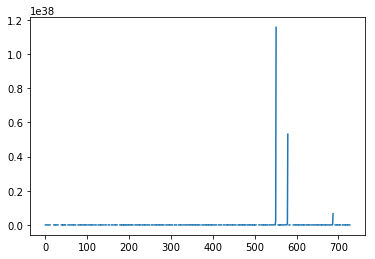

  2%|█▎                                                                           | 370/20835 [00:19<03:08, 108.75it/s]

In [35]:
plt.plot(monitor["loss"]); #with

In [ ]:
save_model_state(model, optimizer, num_epochs, monitor["loss"], path)

In [28]:
def y_predict(data, model, k):
    logging.info("Predicting for training model...")
    with torch.no_grad():
        y_t = []
        y_p = []
        for index, (doc_vec, labs, yin, y01) in enumerate(tqdm(data)):
            # do softmax on the output layer. then sort the indices. or like consider the scores of only
            # the top k indices. convert these to 1s and the rest to 0s. run eval after performing this 
            # conversion.
            score = model.linear.forward(doc_vec)
            y_true = y01.numpy()
            
            softmax_op = F.softmax(score)
            softmax_op = softmax_op.numpy() 
            r = np.zeros_like(softmax_op)
            
#             if y_true.shape != softmax_op.shape:
#                 pad_x = abs(softmax_op.shape[0] - y_true.shape[0])
#                 pad_y = abs(softmax_op.shape[1] - y_true.shape[1])
#                 y_true = np.pad(y_true, [(0, pad_x), (0,0)], "constant")
                
            for each_row in range(len(softmax_op)):
#                 k = np.random.randint(2, k+1)
                k = np.sum(y_true[each_row]).astype(int)
                row_score_list = softmax_op[each_row].tolist()
                max_idx = list(map(row_score_list.index, heapq.nlargest(k, row_score_list)))
                r[each_row][max_idx] = 1

            y_t.append(y_true)
            y_p.append(r)

    yt = np.vstack(y_t)
    yp = np.vstack(y_p)
    
#     if yt.shape != yp.shape:
#         pad_x = abs(yp.shape[0] - yt.shape[0])
#         pad_y = abs(yp.shape[1] - yt.shape[1])
#         yt = np.pad(yt, [(0, pad_x), (0,0)], "constant")
    
    return yt, yp

# yt_, yp_ = y_predict(train_loader, model, 6)

# fscore per class

In [29]:
yt_, yp_ = y_predict(validation_loader, model, 6)
print(classification_report(yt_, yp_))

INFO:root:Predicting for training model...
100%|█████████████████████████████████████████████████████████████████████████████| 2314/2314 [00:06<00:00, 364.93it/s]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.84      0.33      0.47      1083
           2       0.52      0.31      0.39       331
           3       0.25      0.27      0.26       697
           4       0.38      0.57      0.45       606
           5       0.86      0.18      0.30       426
           6       0.00      0.00      0.00        38
           7       0.80      0.73      0.76       221
           8       0.83      0.20      0.32       220
           9       0.00      0.00      0.00        75
          10       0.26      0.83      0.40        35
          11       0.17      0.01      0.02       122
          12       0.32      0.90      0.47        48
          13       0.65      0.56      0.60        27
          14       0.00      0.00      0.00         7
          15       0.70      0.81      0.75        26
          16       0.26      0.03      0.06       145
          17       0.33    

In [ ]:
yt_[1]

In [ ]:
yp_[1]

In [ ]:
yt, yp = y_predict(test_loader, model, 6)
print(classification_report(yt[:,:-2], yp))

In [ ]:
rep = classification_report(yt, yp, output_dict=True)

In [ ]:
repdf = pd.DataFrame.from_dict(rep, orient="index")

In [ ]:
plt.figure(figsize=(12,20))
plt.barh(y = repdf.index, width = repdf["f1-score"])
plt.tight_layout();

In [ ]:
yt[:,:-2].shape, yp.shape

In [ ]:
torch.save({"y_true": yt, "y_pred": yp}, "../saved_models/swiki_test_predictions.pth")

In [ ]:
def s_cut_threshold_predict(data, model):
    logging.info("Evaluating ...")
    yy_t = []
    yy_p = []
    with torch.no_grad():
        for index, (doc_vec, labs, yin, y01) in enumerate(tqdm(data)):
            
            
            W_params = list(model.parameters())[0].data.squeeze()
            
            score = model.linear.forward(doc_vec)
#             score = F.softmax(score)
            score = score.detach().numpy()
            y_index = np.argmax(score, 1)
            
            sc = torch.from_numpy(score)
            sorted_, indices  = torch.sort(sc)
            mid = (sorted_[1:] + sorted_[:-1])/2
            best_thresh, best_f1 = sorted_[0], 0
            y_true = y01
            y_true = y_true.numpy()
            
            for threshold in mid:
                y_pred = np.array(sc > threshold).astype(int)
                f1 = f1_score(y_true, y_pred, average="micro")

                if f1 > best_f1:
                    best_thresh = threshold
                    best_f1 = f1
            
            y_pred = np.array(sc > best_thresh).astype(int)
            
            yy_t.append(y_true)
            yy_p.append(y_pred)
            
    yy_t = np.vstack(yy_t)
    yy_p = np.vstack(yy_p)
    return yy_t, yy_p

y1, y2 = s_cut_threshold_predict(validation_loader, model)

In [ ]:
print(classification_report(y1, y2))

In [ ]:
train_data.iter.MLbin.inverse_transform(yp)[:5] #scoring function

In [ ]:
mod = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
y = torch.Tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active

criterio = nn.BCEWithLogitsLoss()
optimize = torch.optim.SGD(mod.parameters(), lr=1e-1)

for epoch in range(10):
    optimize.zero_grad()
    output = mod(x)
    print(output.data.squeeze())
    los = criterio(output, y)
    los.backward()
    optimize.step()
    print('Loss: {:.3f}'.format(los.item()))

In [ ]:
y = torch.FloatTensor([1, 1, -1])
u = torch.FloatTensor([1, 1, 0])

In [ ]:
y * u

In [ ]:
torch.log2(1+torch.exp(y * u))

In [ ]:
'''
(1, 2), (1, 3), (2, 4) -> edge list
inititalize a matrix of parameters of size: num_classes x num_components.
assume num_classes = 4, num_components = 5

after this, i create a W_pi(n) which is a matrix that has the respective w_pi(n) representation for each n,
i.e. at each row

after this, my aim is to keep updating W in ($%^) such that their eucledian distance minimizes 
'''

In [36]:
W = np.random.randn(5,4)
W_pi = W
W_ans = np.zeros_like(W)
print(W,'\n---\n', W_pi)
print("^"*20)
for i in range(1):
    W_ans[:,0] = 0.5*np.linalg.norm(W[:, 0] - W_pi[:, 1], 2)**2 + 0.5*np.linalg.norm(W[:, 0] - W_pi[:, 2], 2)**2
    W_ans[:,1] = 0.5*np.linalg.norm(W[:, 1] - W_pi[:, 0], 2)**2 + 0.5*np.linalg.norm(W[:, 1] - W_pi[:, 3], 2)**2
    W_ans[:,2] = 0.5*np.linalg.norm(W[:, 2] - W_pi[:, 0], 2)**2
    W_ans[:,3] = 0.5*np.linalg.norm(W[:, 3] - W_pi[:, 2], 2)**2
    print("no func\n", (W_ans))
    print("no func\n", np.mean(W_ans, axis=0))
    print("^"*20)

[[-1.35985602 -0.09033231  0.35838661 -0.11806976]
 [ 0.23111327 -0.67067624 -1.2447228  -0.10620869]
 [ 0.22060692 -0.16869103  0.2035156   0.77664249]
 [ 0.77283405  0.85737137  1.00532603  0.49708194]
 [ 0.35632583  1.94296143  0.78361983 -0.845167  ]] 
---
 [[-1.35985602 -0.09033231  0.35838661 -0.11806976]
 [ 0.23111327 -0.67067624 -1.2447228  -0.10620869]
 [ 0.22060692 -0.16869103  0.2035156   0.77664249]
 [ 0.77283405  0.85737137  1.00532603  0.49708194]
 [ 0.35632583  1.94296143  0.78361983 -0.845167  ]]
^^^^^^^^^^^^^^^^^^^^
no func
 [[5.23420072 7.10877193 2.68368733 2.38147902]
 [5.23420072 7.10877193 2.68368733 2.38147902]
 [5.23420072 7.10877193 2.68368733 2.38147902]
 [5.23420072 7.10877193 2.68368733 2.38147902]
 [5.23420072 7.10877193 2.68368733 2.38147902]]
no func
 [5.23420072 7.10877193 2.68368733 2.38147902]
^^^^^^^^^^^^^^^^^^^^


In [ ]:
edges = [(0,1),
        (0,2),
        (1,3)]
vertices = [0, 1, 2, 3]

In [ ]:
g = ig.Graph(n=4, edges=edges, directed=True, vertex_attrs={"name": vertices})
g.vs["label"] = g.vs["name"]
y = g.layout("kk")

In [ ]:
#($%^)#
np.linalg.norm(W-W_pi, 2, axis=1)